In [2]:
#Amy Independent Research, Fall 2024
import networkx as nx
import osmnx as ox
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import ScrollZoomToggler
import matplotlib.pyplot as plt
import shapely

import osmnx.settings as settings
import osmnx.features as features

ox.__version__

settings.cache_folder = "/tmp/cache"

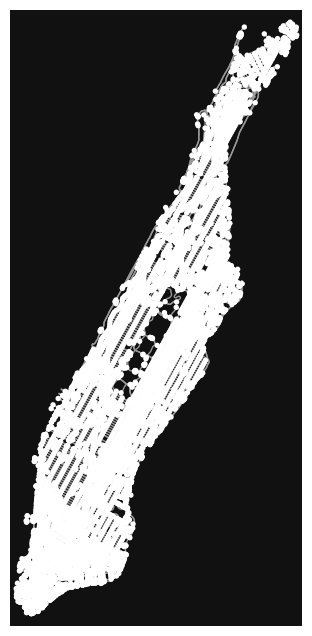

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
42421728,40.798048,-73.960044,traffic_signals,3,NaN,POINT (-73.96004 40.79805)
42421731,40.798654,-73.961474,traffic_signals,3,NaN,POINT (-73.96147 40.79865)
42421737,40.799244,-73.962873,traffic_signals,4,NaN,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,NaN,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,NaN,POINT (-73.96800 40.80140)
...,...,...,...,...,...,...
12214442351,40.721365,-74.010530,NaN,1,NaN,POINT (-74.01053 40.72137)
12214442355,40.721398,-74.010504,NaN,3,NaN,POINT (-74.01050 40.72140)
12214442356,40.721361,-74.010487,NaN,1,NaN,POINT (-74.01049 40.72136)


In [3]:
# Define the place
place = "Manhattan, New York, NY"
# Add the street network to the map
G = ox.graph_from_place(place, network_type="bike")
# Converting street network into graph of nodes and edges
nodes, edges = ox.graph_to_gdfs(G)
# Plotting the graph visually
ox.plot_graph(G)
# Initial Dataframe
nodes, streets = ox.graph_to_gdfs(G)
nodes


In [7]:
# Convert the graph to a GeoDataFrame for easier handling
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Filter streets based on name (e.g., streets that include "Amsterdam/Ft George Av")
improved_streets = edges[edges['name'].str.contains("Broadway", na=False)]



In [13]:
import pandas as pd
import os
from glob import glob

# Define the folder path where the files are located
folder_path = "/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike"

# Create an empty list to store DataFrames
weekly_dataframes = []

# Loop through each year and month from 2021 to 2024 (up to September)
for year in range(2021, 2024):
    for month in range(1, 13):
        # Skip months beyond September in 2024
        if year == 2024 and month > 9:
            continue

        # Format the month as two digits
        formatted_month = f"{month:02d}"

        # Construct the file pattern to match all parts (e.g., _1, _2, etc.)
        file_pattern = os.path.join(folder_path, f"{year}{formatted_month}-citibike-tripdata_*.csv")
        
        # Use glob to find all files matching the pattern
        file_list = glob(file_pattern)

        # Debug: Print the files found
        print(f"Looking for files in: {file_pattern}")
        print(f"Files found: {file_list}")

        # Process each file found for this month
        for file_name in file_list:
            print(f"Processing file: {file_name}")

            # Load the CSV file into a DataFrame
            df = pd.read_csv(file_name, parse_dates=['started_at'])

            # Debug: Check the number of rows loaded
            print(f"Number of rows read from {file_name}: {len(df)}")

            # Skip empty DataFrames
            if df.empty:
                print(f"File {file_name} is empty. Skipping.")
                continue

            # Ensure 'started_at' is a datetime object
            df['start_date'] = pd.to_datetime(df['started_at'])

            # Set 'start_date' as the index for resampling
            df.set_index('start_date', inplace=True)

            # Resample to weekly, counting the number of rides per week
            weekly_rides = df.resample('W')['ride_id'].count().reset_index()
            weekly_rides.rename(columns={'ride_id': 'total_rides'}, inplace=True)

            # Add the year and week number columns using the isocalendar function
            weekly_rides['year'] = weekly_rides['start_date'].dt.year
            weekly_rides['week_number'] = weekly_rides['start_date'].dt.isocalendar().week

            # Add the weekly data to the list
            weekly_dataframes.append(weekly_rides)

# Combine all the weekly DataFrames into a single DataFrame
if weekly_dataframes:
    combined_weekly_data = pd.concat(weekly_dataframes, ignore_index=True)
    # Save the combined data to a CSV file
    output_file = os.path.join(folder_path, "citibike_weekly_ridership.csv")
    combined_weekly_data.to_csv(output_file, index=False)
    print(f"Weekly aggregated data saved to {output_file}")
else:
    print("No weekly data was generated. Please check your file paths and data.")



Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_2.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_2.csv: 98300
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202102-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202102-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202102-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202102-citibike-tripdata_1.csv: 636789
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_2.csv: 499917
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_3.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_3.csv: 25992
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_3.csv: 670048
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_4.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_4.csv: 113405
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_4.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_4.csv: 21509
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_2.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_4.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_4.csv: 13198
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_3.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_4.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_4.csv: 219934
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_4.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_4.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_4.csv: 10986
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_3.csv: 113543
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_2.csv: 706501
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_2.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_2.csv: 24555
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_2.csv: 197312
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_2.csv: 845965
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_3.csv: 260790
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_3.csv: 865425
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_4.csv: 343914
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_2.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_4.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_4.csv: 397932
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_4.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_4.csv: 576020
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_4.csv: 411866
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_3.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_3.csv: 936584
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_3.csv: 386394
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_2.csv: 592049
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_2.csv: 795412
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_2.csv: 696171
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_3.csv
Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_3.csv: 118932
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_1.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_3.csv: 749716
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_1.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_4.csv: 453152
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_3.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_4.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_4.csv: 451549
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_3.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_2.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_4.csv: 659581
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_3.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_2.csv: 1000000
Looking for files in: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_*.csv
Files found: ['/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_4.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_1.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_2.csv', '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_3.csv']
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_4.csv: 964180
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_1.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_2.csv: 1000000
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/772993138.py:36: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


Number of rows read from /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_3.csv: 1000000


KeyboardInterrupt: 

In [17]:
import pandas as pd
import os
from glob import glob

# Define the folder path where the files are located
folder_path = "/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike"

# Create an empty list to store DataFrames
weekly_dataframes = []

# Define bounding boxes for each borough
def get_borough(lat, lng):
    if 40.70 <= lat <= 40.88 and -74.02 <= lng <= -73.90:
        return 'Manhattan'
    elif 40.57 <= lat <= 40.73 and -74.04 <= lng <= -73.85:
        return 'Brooklyn'
    elif 40.54 <= lat <= 40.80 and -73.95 <= lng <= -73.70:
        return 'Queens'
    elif 40.79 <= lat <= 40.91 and -73.93 <= lng <= -73.80:
        return 'Bronx'
    elif 40.49 <= lat <= 40.65 and -74.25 <= lng <= -74.05:
        return 'Staten Island'
    else:
        return 'Other'

# Loop through each year and month from 2021 to 2024 (up to September)
for year in range(2021, 2025):
    for month in range(1, 13):
        # Skip months beyond September in 2024
        if year == 2024 and month > 9:
            continue

        # Format the month as two digits
        formatted_month = f"{month:02d}"

        # Construct the file pattern to match all parts (e.g., _1, _2, etc.)
        file_pattern = os.path.join(folder_path, f"{year}{formatted_month}-citibike-tripdata_*.csv")
        
        # Use glob to find all files matching the pattern
        file_list = glob(file_pattern)

        # Process each file found for this month
        for file_name in file_list:
            print(f"Processing file: {file_name}")

            # Load the CSV file into a DataFrame
            df = pd.read_csv(file_name, parse_dates=['started_at'])

            # Apply the get_borough function to classify each trip
            df['borough'] = df.apply(lambda row: get_borough(row['start_lat'], row['start_lng']), axis=1)

            # Extract day and week information
            df['date'] = df['started_at'].dt.date
            df['week'] = df['started_at'].dt.isocalendar().week
            df['year'] = df['started_at'].dt.year

            # Total daily trips for NYC
            daily_trips_nyc = df.groupby(['date']).size().reset_index(name='total_trips_nyc')

            # Total daily trips for each borough
            daily_trips_boroughs = df.groupby(['date', 'borough']).size().unstack(fill_value=0).reset_index()

            # Merge the daily data into a single DataFrame
            combined_daily = pd.merge(daily_trips_nyc, daily_trips_boroughs, on='date', how='left')

            # Fill NaN values with 0 (for days with no trips recorded)
            combined_daily.fillna(0, inplace=True)

            # Calculate average daily trips per week
            weekly_trips = combined_daily.groupby(['year', 'week']).mean().reset_index()

            # Rename columns to reflect that these are averages
            weekly_trips.rename(columns={
                'total_trips_nyc': 'avg_daily_trips_nyc',
                'Manhattan': 'avg_daily_trips_manhattan',
                'Brooklyn': 'avg_daily_trips_brooklyn',
                'Queens': 'avg_daily_trips_queens',
                'Bronx': 'avg_daily_trips_bronx',
                'Staten Island': 'avg_daily_trips_staten_island'
            }, inplace=True)

            # Add the weekly data to the list
            weekly_dataframes.append(weekly_trips)

# Combine all the weekly DataFrames into a single DataFrame
if weekly_dataframes:
    combined_weekly_data = pd.concat(weekly_dataframes, ignore_index=True)
    # Save the combined data to a CSV file
    output_file = os.path.join(folder_path, "citibike_avg_daily_weekly_ridership.csv")
    combined_weekly_data.to_csv(output_file, index=False)
    print(f"Weekly aggregated data saved to {output_file}")
else:
    print("No weekly data was generated. Please check your file paths and data.")


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_27086/2766761306.py:47: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_name, parse_dates=['started_at'])


KeyError: 'year'

In [17]:
file_path = "/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_2.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


In [35]:
# Define bounding boxes for each borough
def get_borough(lat, lng):
    if 40.70 <= lat <= 40.88 and -74.02 <= lng <= -73.90:
        return 'Manhattan'
    elif 40.57 <= lat <= 40.73 and -74.04 <= lng <= -73.85:
        return 'Brooklyn'
    elif 40.54 <= lat <= 40.80 and -73.95 <= lng <= -73.70:
        return 'Queens'
    elif 40.79 <= lat <= 40.91 and -73.93 <= lng <= -73.80:
        return 'Bronx'
    elif 40.49 <= lat <= 40.65 and -74.25 <= lng <= -74.05:
        return 'Staten Island'
    else:
        return 'Other'

# Apply the get_borough function to each row to determine the borough based on latitude and longitude
df['borough'] = df.apply(lambda row: get_borough(row['start_lat'], row['start_lng']), axis=1)

# Convert 'started_at' to datetime
df['started_at'] = pd.to_datetime(df['started_at'])
# Extract year and month (if not already done)
df['year'] = df['started_at'].dt.year
df['month'] = df['started_at'].dt.month

# Create 'year', 'week_number', 'month', and 'day_of_week' columns
df['year'] = df['started_at'].dt.year
df['month'] = df['started_at'].dt.month
df['week_number'] = ((df['started_at'] - start_date).dt.days // 7) + 1
df['day_of_week'] = df['started_at'].dt.weekday  # 0=Monday, 6=Sunday

# Step 1: Aggregate weekly data
# Calculate total trips per week
weekly_aggregated = df.groupby(['year', 'week_number', 'borough']).agg(
    total_trips=('ride_id', 'count'),
    weekday_trips=('ride_id', lambda x: x[df['started_at'].dt.weekday < 5].count()),  # Weekdays (Mon-Fri)
    weekend_trips=('ride_id', lambda x: x[df['started_at'].dt.weekday >= 5].count()),  # Weekends (Sat-Sun)
).reset_index()

# Keep only rows where the year is 2021 or later
weekly_aggregated = weekly_aggregated[weekly_aggregated['year'] >= 2021]

# Step 2: Calculate average daily trips per week
weekly_aggregated['avg_daily_trips'] = weekly_aggregated['total_trips'] / 7
weekly_aggregated['avg_weekday_trips'] = weekly_aggregated['weekday_trips'] / 5  # Avg trips during weekdays
weekly_aggregated['avg_weekend_trips'] = weekly_aggregated['weekend_trips'] / 2  # Avg trips during weekends

# Reset the index if needed
weekly_aggregated.reset_index(drop=True, inplace=True)

# Display the aggregated DataFrame
print(weekly_aggregated)

    year  week_number    borough  total_trips  weekday_trips  weekend_trips  \
0   2021            1      Bronx          121             89             32   
1   2021            1   Brooklyn         2106           1542            564   
2   2021            1  Manhattan        18351          13860           4491   
3   2021            2      Bronx           96             62             34   
4   2021            2   Brooklyn         2553           1811            742   
5   2021            2  Manhattan        22206          16921           5285   
6   2021            3      Bronx           97             60             37   
7   2021            3   Brooklyn         2676           1807            869   
8   2021            3  Manhattan        22202          16021           6181   
9   2021            4      Bronx           61             42             19   
10  2021            4   Brooklyn         2149           1535            614   
11  2021            4  Manhattan        19099       

In [40]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [44]:
from tqdm import tqdm
import pandas as pd
import glob

# Define the function for borough assignment based on lat/lng
def get_borough(lat, lng):
    if 40.70 <= lat <= 40.88 and -74.02 <= lng <= -73.90:
        return 'Manhattan'
    elif 40.57 <= lat <= 40.73 and -74.04 <= lng <= -73.85:
        return 'Brooklyn'
    elif 40.54 <= lat <= 40.80 and -73.95 <= lng <= -73.70:
        return 'Queens'
    elif 40.79 <= lat <= 40.91 and -73.93 <= lng <= -73.80:
        return 'Bronx'
    elif 40.49 <= lat <= 40.65 and -74.25 <= lng <= -74.05:
        return 'Staten Island'
    else:
        return 'Other'

# Define the path to your files (adjust this to your folder location)
path = '/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/*.csv'

# Initialize an empty DataFrame to store the aggregated results
final_weekly_data = pd.DataFrame()

# Loop through each CSV file in the specified folder
for file in glob.glob(path):
    print(f"Processing file: {file}")
    
    # Load the data
    df = pd.read_csv(file)
    
    # Convert 'started_at' to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    
    # Apply the get_borough function to each row to determine the borough based on latitude and longitude
    df['borough'] = df.apply(lambda row: get_borough(row['start_lat'], row['start_lng']), axis=1)
    
    # Extract year and week number
    start_date = pd.Timestamp('2021-01-01')
    df['year'] = df['started_at'].dt.year
    df['week_number'] = ((df['started_at'] - start_date).dt.days // 7) + 1
    
    # Aggregate the data to weekly summaries
    weekly_aggregated = df.groupby(['year', 'week_number', 'borough']).agg(
        total_trips=('ride_id', 'count'),
        weekday_trips=('ride_id', lambda x: x[df['started_at'].dt.weekday < 5].count()),
        weekend_trips=('ride_id', lambda x: x[df['started_at'].dt.weekday >= 5].count()),
    ).reset_index()

    # Append the aggregated data directly to the final DataFrame
    final_weekly_data = pd.concat([final_weekly_data, weekly_aggregated], ignore_index=True)

# Combine rows with the same week_number, year, and borough by summing their values
final_weekly_data = final_weekly_data.groupby(['year', 'week_number', 'borough']).agg(
    total_trips=('total_trips', 'sum'),
    weekday_trips=('weekday_trips', 'sum'),
    weekend_trips=('weekend_trips', 'sum')
).reset_index()

# Calculate average daily trips per week
final_weekly_data['avg_daily_trips'] = final_weekly_data['total_trips'] / 7
final_weekly_data['avg_weekday_trips'] = final_weekly_data['weekday_trips'] / 5
final_weekly_data['avg_weekend_trips'] = final_weekly_data['weekend_trips'] / 2

# Reset the index if needed
final_weekly_data.reset_index(drop=True, inplace=True)

# Display the final combined DataFrame
print("Final combined weekly data:")
print(final_weekly_data.head())

Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202405-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202312-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202312-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202405-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202404-citibike-tripdata.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202312-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202301-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202405-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202106-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202405-citibike-tripdata_5.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202207-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202208-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202405-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202109-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202102-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202111-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202203-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202305-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202210-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202309-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['started_at'] = pd.to_datetime(df['started_at'])


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202309-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202409-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202406-citibike-tripdata_5.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202112-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202101-citibike-tripdata_2.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202406-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202409-citibike-tripdata_5.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202309-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202306-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202409-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202311-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202402-citibike-tripdata.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202406-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202309-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202406-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202409-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202311-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202311-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202204-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202302-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202409-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202105-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202406-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202202-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_4.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202103-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_4.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202304-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202211-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202110-citibike-tripdata_4.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202209-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202206-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202108-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202107-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_3.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202408-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202407-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202310-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202310-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202407-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202408-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202407-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202401-citibike-tripdata.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202310-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202303-citibike-tripdata_3.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202205-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202408-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202104-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202407-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202408-citibike-tripdata_5.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_2.csv
Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202310-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202408-citibike-tripdata_4.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202407-citibike-tripdata_5.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202201-citibike-tripdata_1.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202403-citibike-tripdata.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202212-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202307-citibike-tripdata_2.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Processing file: /Users/amyxqc/Desktop/amy_bikenycfall2024/Data/CitiBike/202308-citibike-tripdata_3.csv


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3685504816.py:31: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Final combined weekly data:
   year  week_number    borough  total_trips  weekday_trips  weekend_trips  \
0  2019          -89  Manhattan            1              0              1   
1  2019          -86  Manhattan            1              1              0   
2  2019          -84   Brooklyn            1              1              0   
3  2019          -84  Manhattan            1              1              0   
4  2019          -79   Brooklyn            1              1              0   

   avg_daily_trips  avg_weekday_trips  avg_weekend_trips  
0         0.142857                0.0                0.5  
1         0.142857                0.2                0.0  
2         0.142857                0.2                0.0  
3         0.142857                0.2                0.0  
4         0.142857                0.2                0.0  


In [46]:
print(final_weekly_data)

     year  week_number    borough  total_trips  weekday_trips  weekend_trips  \
0    2019          -89  Manhattan            1              0              1   
1    2019          -86  Manhattan            1              1              0   
2    2019          -84   Brooklyn            1              1              0   
3    2019          -84  Manhattan            1              1              0   
4    2019          -79   Brooklyn            1              1              0   
..    ...          ...        ...          ...            ...            ...   
902  2024          195     Queens        15154          10671           4483   
903  2024          196      Bronx         5347           3722           1625   
904  2024          196   Brooklyn        94233          60554          33679   
905  2024          196  Manhattan       403838         279903         123935   
906  2024          196     Queens         6503           4341           2162   

     avg_daily_trips  avg_weekday_trips

In [49]:
# Filter to keep only dates from 2021 and beyond
# Filter out rows where the 'year' column is less than 2021
final_weekly_data = final_weekly_data[final_weekly_data['year'] >= 2021]

# Optional: Reset the index if you want a clean index after filtering
final_weekly_data.reset_index(drop=True, inplace=True)

print (final_weekly_data)

     year  week_number    borough  total_trips  weekday_trips  weekend_trips  \
0    2021            1      Bronx          544            404            140   
1    2021            1   Brooklyn        27858          20350           7508   
2    2021            1  Manhattan       197947         149658          48289   
3    2021            2      Bronx          533            410            123   
4    2021            2   Brooklyn        34343          24741           9602   
..    ...          ...        ...          ...            ...            ...   
798  2024          195     Queens        15154          10671           4483   
799  2024          196      Bronx         5347           3722           1625   
800  2024          196   Brooklyn        94233          60554          33679   
801  2024          196  Manhattan       403838         279903         123935   
802  2024          196     Queens         6503           4341           2162   

     avg_daily_trips  avg_weekday_trips

In [50]:
# Example: Save to the Desktop
final_weekly_data.to_csv('/Users/amyxqc/Desktop/amy_bikenycfall2024/Data/Final/final_weekly_data.csv', index=False)

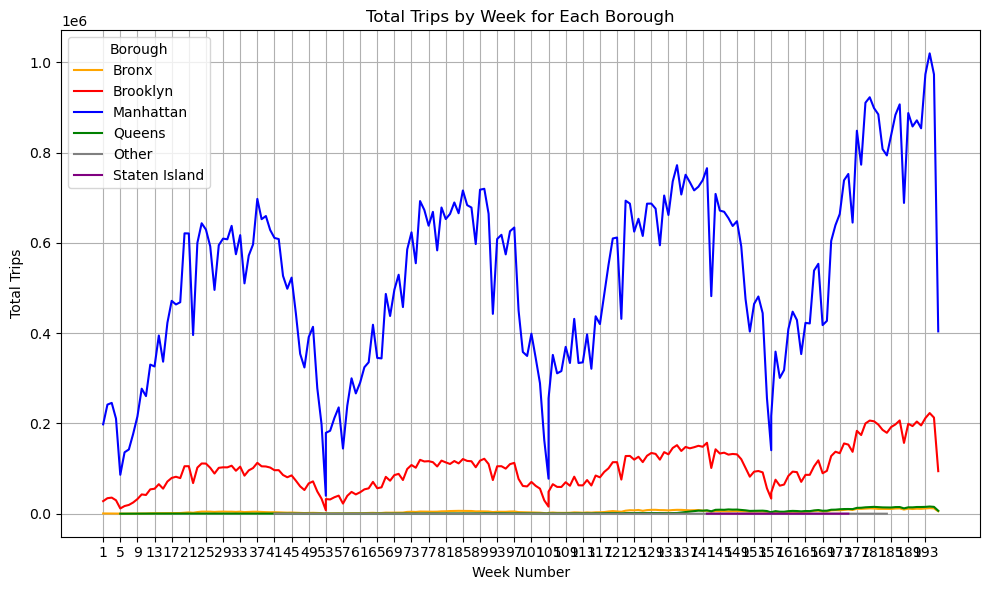

In [51]:
import matplotlib.pyplot as plt

# Assuming `final_weekly_data` is your DataFrame with columns: 'year', 'week_number', 'borough', 'total_trips'

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Define a color map for different boroughs
colors = {
    'Manhattan': 'blue',
    'Brooklyn': 'red',
    'Queens': 'green',
    'Bronx': 'orange',
    'Staten Island': 'purple'
}

# Plot each borough's trips as a line
for borough in final_weekly_data['borough'].unique():
    subset = final_weekly_data[final_weekly_data['borough'] == borough]
    plt.plot(subset['week_number'], subset['total_trips'], 
             label=borough, color=colors.get(borough, 'gray'))

# Add labels and title
plt.title('Total Trips by Week for Each Borough')
plt.xlabel('Week Number')
plt.ylabel('Total Trips')
plt.xticks(range(1, final_weekly_data['week_number'].max() + 1, 4))  # Adjust x-ticks for better readability
plt.legend(title='Borough', loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


OSError: [Errno 30] Read-only file system: '/citi_bike_trips_per_week.png'

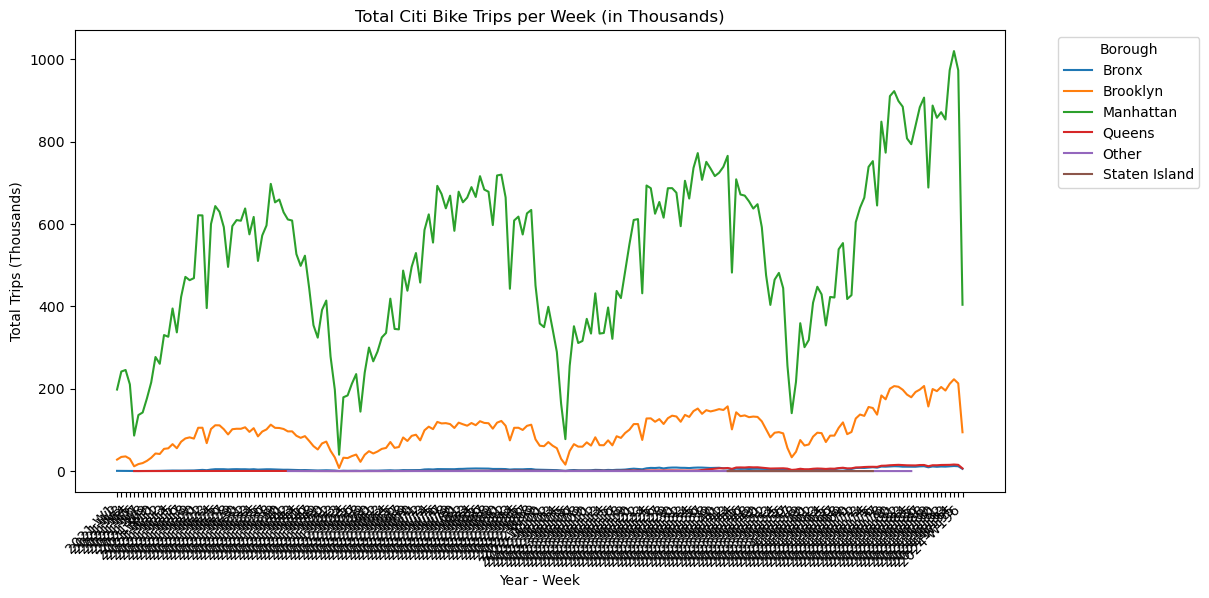

In [55]:
# Adjust the total trips to thousands for easier readability in the plot
final_weekly_data['total_trips_thousands'] = final_weekly_data['total_trips'] / 1000

# Create a new column for 'year-week' to use as x-axis labels
final_weekly_data['year_week'] = final_weekly_data['year'].astype(str) + '-W' + final_weekly_data['week_number'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Iterate over the boroughs and plot each one
for borough in final_weekly_data['borough'].unique():
    subset = final_weekly_data[final_weekly_data['borough'] == borough]
    plt.plot(subset['year_week'], subset['total_trips_thousands'], label=borough)

# Adding labels and title
plt.title('Total Citi Bike Trips per Week (in Thousands)')
plt.xlabel('Year - Week')
plt.ylabel('Total Trips (Thousands)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend to differentiate between boroughs
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as an image
plt.savefig('citi_bike_trips_per_week.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3298957153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['total_trips_thousands'] = filtered_data['total_trips'] / 1000
/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/3298957153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_week'] = filtered_data['year'].astype(str) + '-W' + filtered_data['week_number'].astype(str)


OSError: [Errno 30] Read-only file system: '/citi_bike_trips_from_week_157.png'

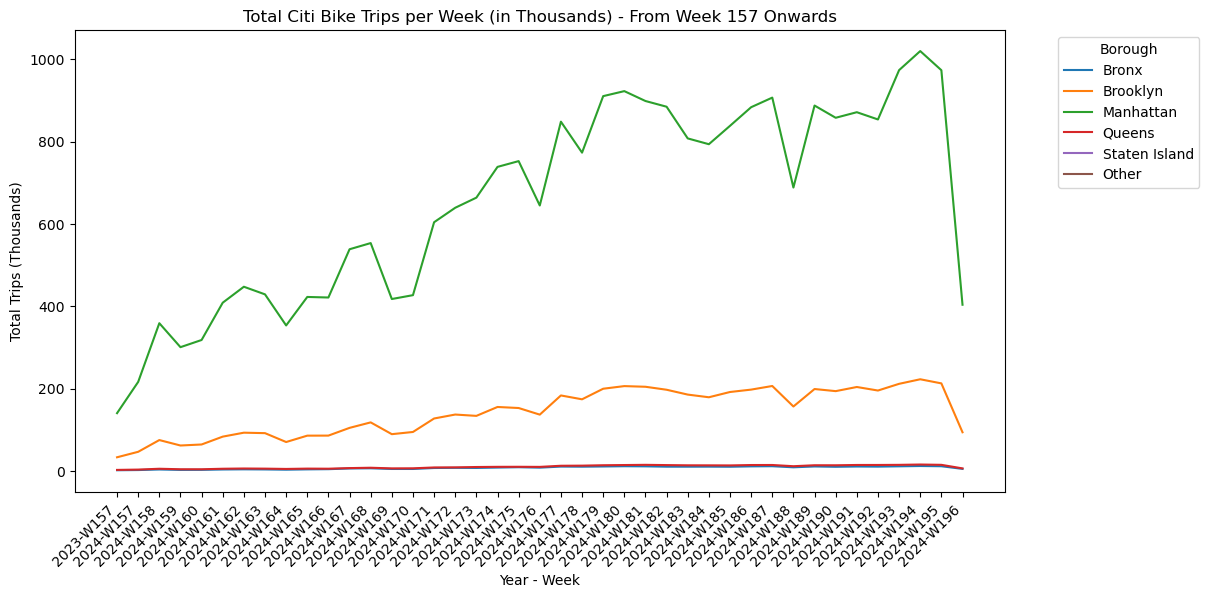

In [56]:
# Filter data to include only weeks from 157 onward
filtered_data = final_weekly_data[final_weekly_data['week_number'] >= 157]

# Adjust the total trips to thousands for easier readability in the plot
filtered_data['total_trips_thousands'] = filtered_data['total_trips'] / 1000

# Create a new column for 'year-week' to use as x-axis labels
filtered_data['year_week'] = filtered_data['year'].astype(str) + '-W' + filtered_data['week_number'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Iterate over the boroughs and plot each one
for borough in filtered_data['borough'].unique():
    subset = filtered_data[filtered_data['borough'] == borough]
    plt.plot(subset['year_week'], subset['total_trips_thousands'], label=borough)

# Adding labels and title
plt.title('Total Citi Bike Trips per Week (in Thousands) - From Week 157 Onwards')
plt.xlabel('Year - Week')
plt.ylabel('Total Trips (Thousands)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend to differentiate between boroughs
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as an image
plt.savefig('citi_bike_trips_from_week_157.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()



/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/2820143718.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['total_trips_hundreds'] = filtered_data['total_trips'] / 100
/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/2820143718.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year_week'] = filtered_data['year'].astype(str) + '-W' + filtered_data['week_number'].astype(str)


OSError: [Errno 30] Read-only file system: '/citi_bike_trips_from_week_157_excluding_manhattan_hundreds.png'

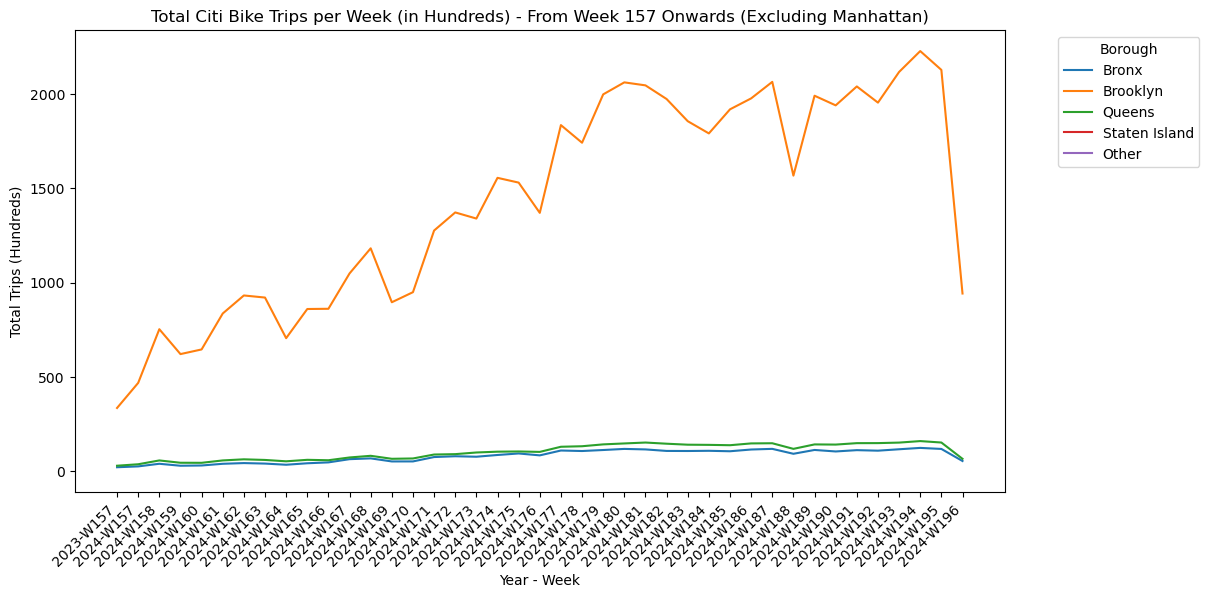

In [57]:
# Filter data to include only weeks from 157 onward and exclude Manhattan
filtered_data = final_weekly_data[(final_weekly_data['week_number'] >= 157) & (final_weekly_data['borough'] != 'Manhattan')]

# Adjust the total trips to hundreds for easier readability in the plot
filtered_data['total_trips_hundreds'] = filtered_data['total_trips'] / 100

# Create a new column for 'year-week' to use as x-axis labels
filtered_data['year_week'] = filtered_data['year'].astype(str) + '-W' + filtered_data['week_number'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Iterate over the boroughs and plot each one, excluding Manhattan
for borough in filtered_data['borough'].unique():
    subset = filtered_data[filtered_data['borough'] == borough]
    plt.plot(subset['year_week'], subset['total_trips_hundreds'], label=borough)

# Adding labels and title
plt.title('Total Citi Bike Trips per Week (in Hundreds) - From Week 157 Onwards (Excluding Manhattan)')
plt.xlabel('Year - Week')
plt.ylabel('Total Trips (Hundreds)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend to differentiate between boroughs
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as an image
plt.savefig('citi_bike_trips_from_week_157_excluding_manhattan_hundreds.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/2369973619.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['total_trips_tens'] = filtered_data['total_trips'] / 10
/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/2369973619.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['week_number_str'] = 'W' + filtered_data['week_number'].astype(str)


OSError: [Errno 30] Read-only file system: '/citi_bike_trips_bronx_queens_tens.png'

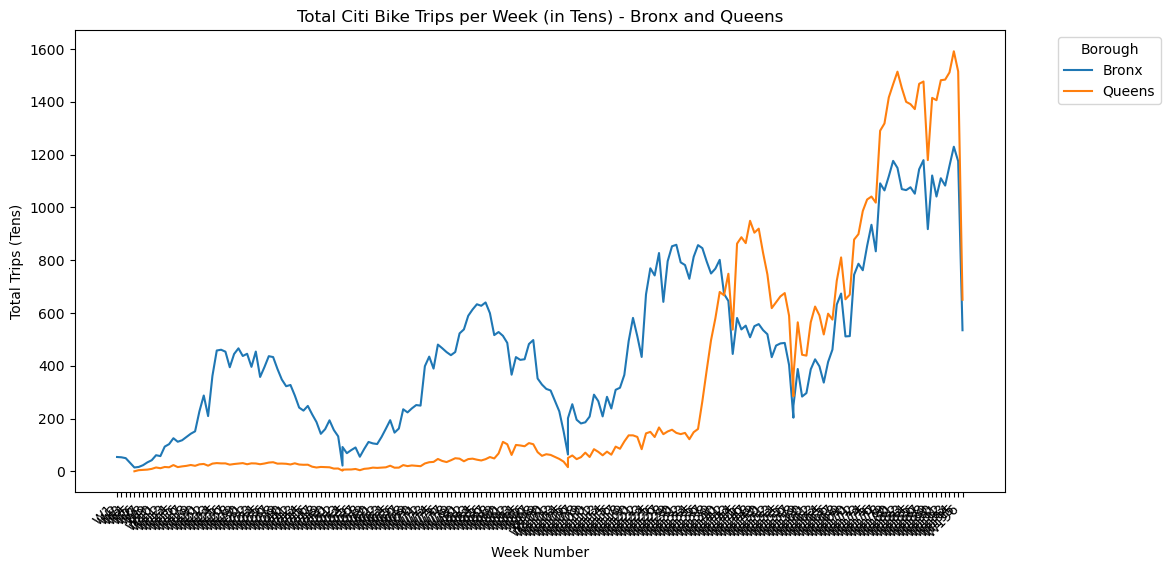

In [62]:
import matplotlib.pyplot as plt

# Filter data to include only Bronx and Queens
filtered_data = final_weekly_data[final_weekly_data['borough'].isin(['Bronx', 'Queens'])]

# Adjust the total trips to tens for easier readability in the plot
filtered_data['total_trips_tens'] = filtered_data['total_trips'] / 10

# Create a new column for 'year-week' to use as x-axis labels
filtered_data['week_number_str'] = 'W' + filtered_data['week_number'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Iterate over the selected boroughs (Bronx and Queens) and plot each one
for borough in filtered_data['borough'].unique():
    subset = filtered_data[filtered_data['borough'] == borough]
    plt.plot(subset['week_number_str'], subset['total_trips_tens'], label=borough)

# Adding labels and title
plt.title('Total Citi Bike Trips per Week (in Tens) - Bronx and Queens')
plt.xlabel('Week Number')
plt.ylabel('Total Trips (Tens)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend to differentiate between Bronx and Queens
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as an image
plt.savefig('citi_bike_trips_bronx_queens_tens.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()



/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/1429490688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brooklyn_data['avg_weekday_trips_hundreds'] = brooklyn_data['avg_weekday_trips'] / 100
/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/1429490688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brooklyn_data['avg_weekend_trips_hundreds'] = brooklyn_data['avg_weekend_trips'] / 100
/var/folders/30/jfztb8191jzff8_xz9n0d59m0000gn/T/ipykernel_24250/1429490688.py:9: 

OSError: [Errno 30] Read-only file system: '/citi_bike_trips_brooklyn_weekday_weekend_hundreds.png'

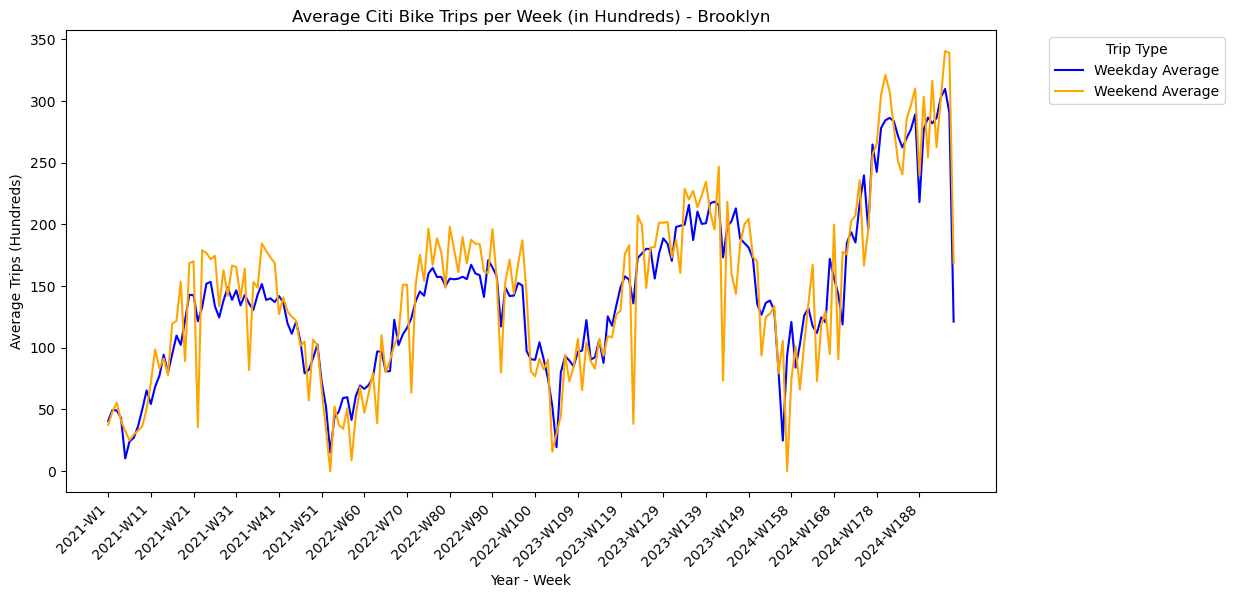

In [63]:
# Filter data to include only Brooklyn
brooklyn_data = final_weekly_data[final_weekly_data['borough'] == 'Brooklyn']

# Adjust the averages to hundreds for easier readability in the plot
brooklyn_data['avg_weekday_trips_hundreds'] = brooklyn_data['avg_weekday_trips'] / 100
brooklyn_data['avg_weekend_trips_hundreds'] = brooklyn_data['avg_weekend_trips'] / 100

# Create a new column for 'year-week' to use as x-axis labels
brooklyn_data['year_week'] = brooklyn_data['year'].astype(str) + '-W' + brooklyn_data['week_number'].astype(str)

# Sort data by 'year' and 'week_number' to ensure chronological order
brooklyn_data.sort_values(['year', 'week_number'], inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

# Plot average weekday trips
plt.plot(brooklyn_data['year_week'], brooklyn_data['avg_weekday_trips_hundreds'], label='Weekday Average', color='blue')

# Plot average weekend trips
plt.plot(brooklyn_data['year_week'], brooklyn_data['avg_weekend_trips_hundreds'], label='Weekend Average', color='orange')

# Adding labels and title
plt.title('Average Citi Bike Trips per Week (in Hundreds) - Brooklyn')
plt.xlabel('Year - Week')
plt.ylabel('Average Trips (Hundreds)')

# Reduce the number of x-axis labels by displaying every 10th label
plt.xticks(ticks=range(0, len(brooklyn_data['year_week']), 10),
           labels=brooklyn_data['year_week'][::10], rotation=45, ha='right')

# Add a legend to differentiate between weekday and weekend averages
plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the plot as an image
plt.savefig('citi_bike_trips_brooklyn_weekday_weekend_hundreds.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


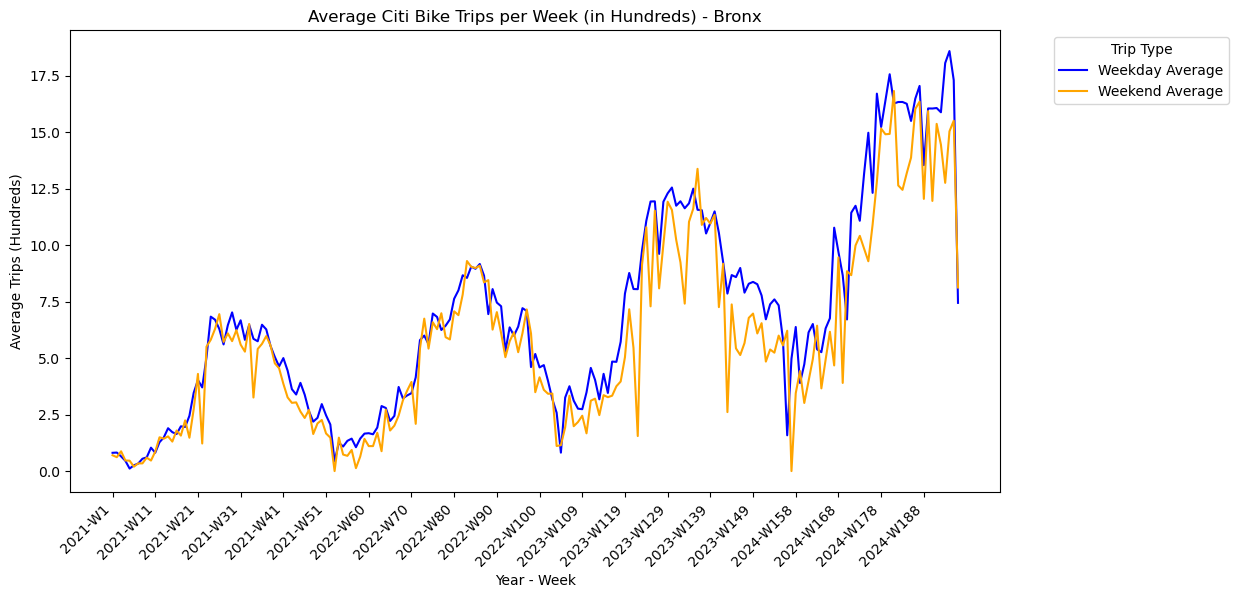

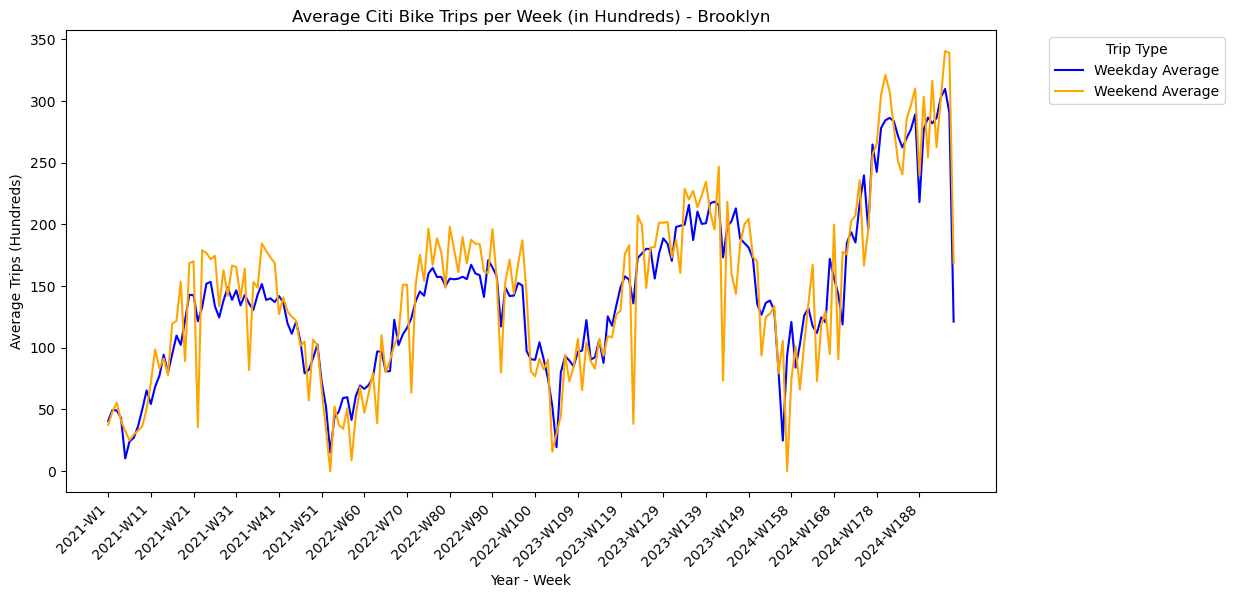

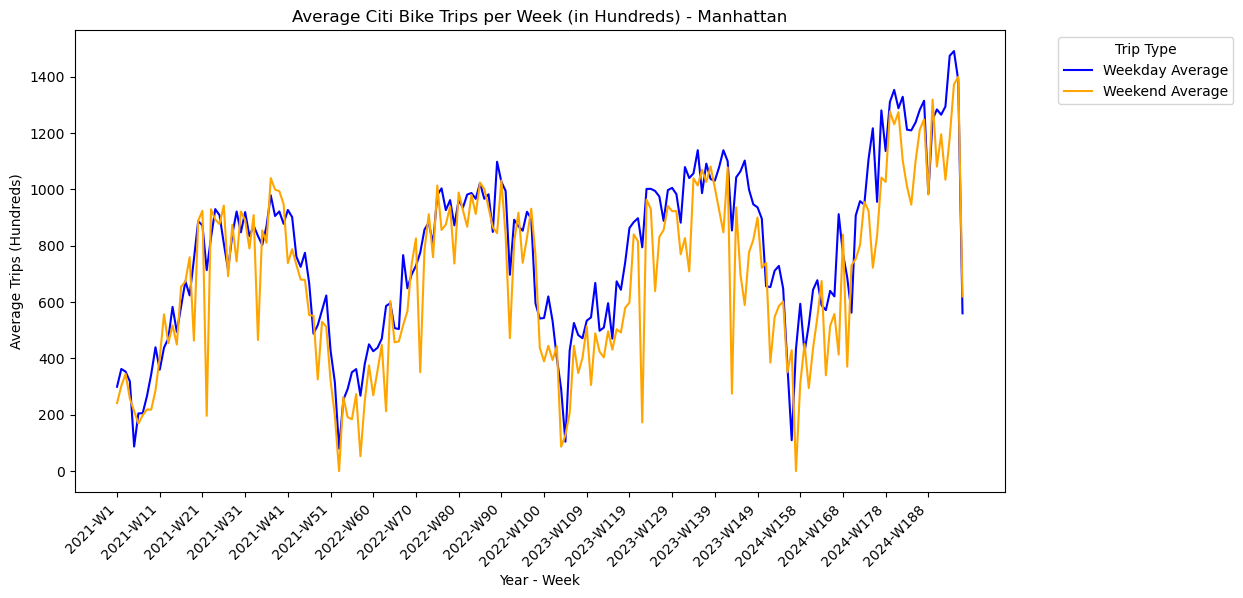

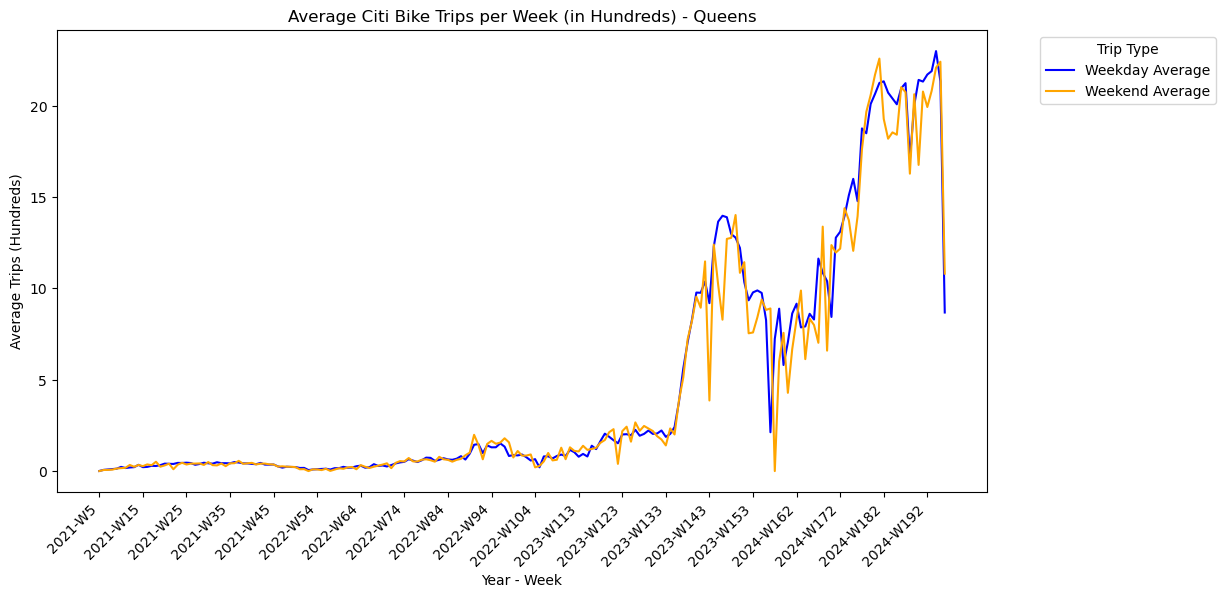

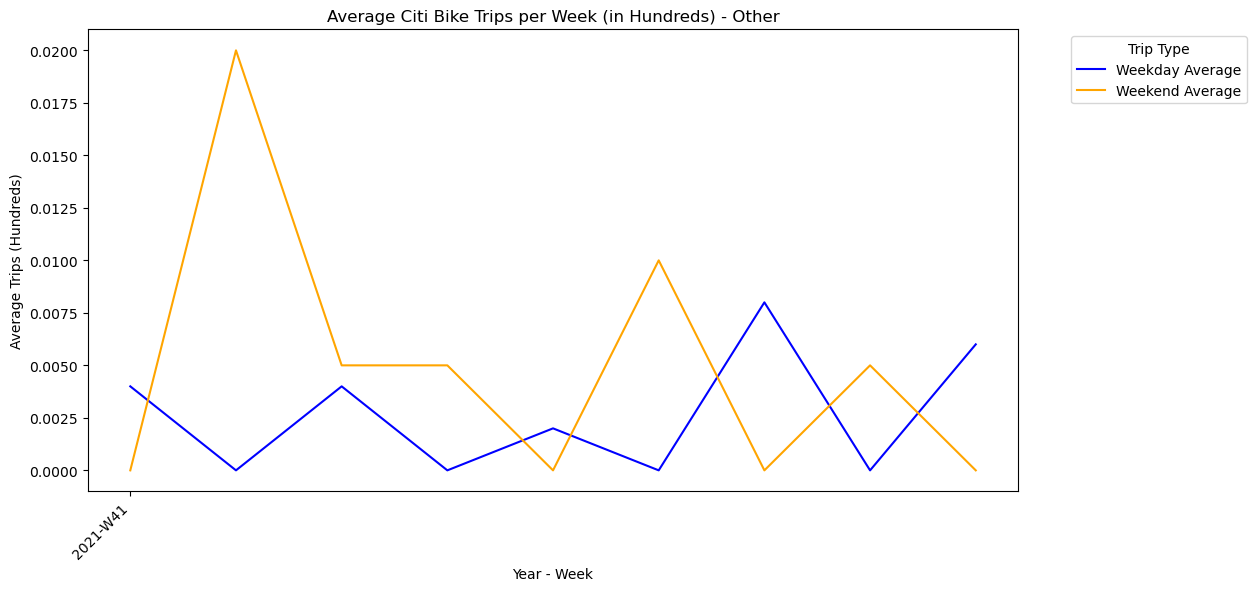

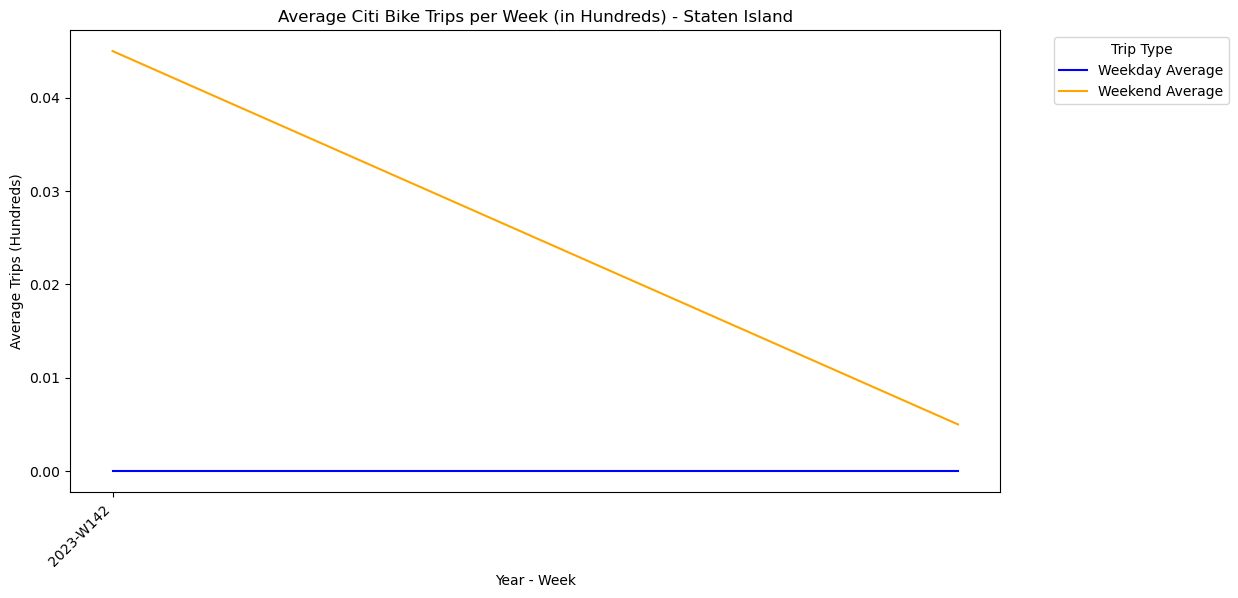

In [65]:
# Adjust the averages to hundreds for easier readability in the plot
final_weekly_data['avg_weekday_trips_hundreds'] = final_weekly_data['avg_weekday_trips'] / 100
final_weekly_data['avg_weekend_trips_hundreds'] = final_weekly_data['avg_weekend_trips'] / 100

# Create a new column for 'year-week' to use as x-axis labels
final_weekly_data['year_week'] = final_weekly_data['year'].astype(str) + '-W' + final_weekly_data['week_number'].astype(str)

# Iterate over each unique borough
for borough in final_weekly_data['borough'].unique():
    # Filter data for the current borough
    borough_data = final_weekly_data[final_weekly_data['borough'] == borough].copy()

    # Sort data by 'year' and 'week_number' to ensure chronological order
    borough_data.sort_values(['year', 'week_number'], inplace=True)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot average weekday trips
    plt.plot(borough_data['year_week'], borough_data['avg_weekday_trips_hundreds'], label='Weekday Average', color='blue')

    # Plot average weekend trips
    plt.plot(borough_data['year_week'], borough_data['avg_weekend_trips_hundreds'], label='Weekend Average', color='orange')

    # Adding labels and title
    plt.title(f'Average Citi Bike Trips per Week (in Hundreds) - {borough}')
    plt.xlabel('Year - Week')
    plt.ylabel('Average Trips (Hundreds)')

    # Reduce the number of x-axis labels by displaying every 10th label
    plt.xticks(ticks=range(0, len(borough_data['year_week']), 10),
               labels=borough_data['year_week'][::10], rotation=45, ha='right')

    # Add a legend to differentiate between weekday and weekend averages
    plt.legend(title='Trip Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Display the plot
    plt.show()
